# Operational & Model Risk Module

**Focus:** Operational risk (systems/process/governance failures) and model risk (limitations in quantitative frameworks). Build a risk **heatmap**, assess **scenario probabilities**, simulate losses with a simple **Loss Distribution Approach (LDA)**, and discuss **model validation** processes used by banks and regulators.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import poisson, lognorm, norm
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')


## Learning Objectives
- Design a **risk heatmap** with likelihood vs impact.
- Elicit **scenario probabilities** and severities; aggregate tail risk.
- Simulate operational losses via a simple **Loss Distribution Approach (LDA)** (Poisson frequency + Lognormal severity).
- Build a **model risk inventory** and a **validation checklist** with scoring.
- Discuss how qualitative governance complements quantitative analytics.

## 1) Build a Risk Heatmap (RCSA-style)

In [2]:
likelihood_scale = ['Rare','Unlikely','Possible','Likely','Almost Certain']
impact_scale = ['Insignificant','Minor','Moderate','Major','Severe']

# Example risks (edit freely)
risks = pd.DataFrame([
    {'Risk':'Payment system outage','Likelihood':'Likely','Impact':'Major'},
    {'Risk':'Cyber intrusion (data exfil)','Likelihood':'Possible','Impact':'Severe'},
    {'Risk':'Third-party failure','Likelihood':'Possible','Impact':'Moderate'},
    {'Risk':'Regulatory non-compliance','Likelihood':'Unlikely','Impact':'Major'},
    {'Risk':'Fraud (internal)','Likelihood':'Unlikely','Impact':'Moderate'},
], columns=['Risk','Likelihood','Impact'])

# Map to numeric grid
like_map = {k:i for i,k in enumerate(likelihood_scale)}
imp_map = {k:i for i,k in enumerate(impact_scale)}
risks['L_idx'] = risks['Likelihood'].map(like_map)
risks['I_idx'] = risks['Impact'].map(imp_map)

# Heat matrix: count risks per cell
heat = pd.DataFrame(0, index=likelihood_scale, columns=impact_scale)
for _, r in risks.iterrows():
    heat.loc[r['Likelihood'], r['Impact']] += 1

heat

,Insignificant,Minor,Moderate,Major,Severe
Rare,0,0,0,0,0
Unlikely,0,0,1,1,0
Possible,0,0,1,0,1
Likely,0,0,0,1,0
Almost Certain,0,0,0,0,0


### Plot Heatmap (counts per cell)

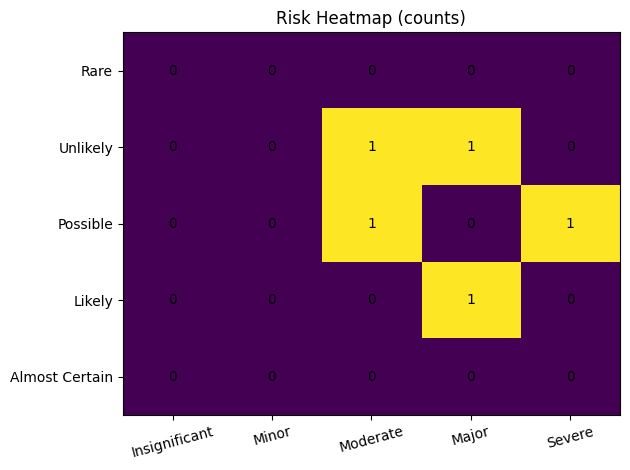

In [3]:
plt.figure()
plt.imshow(heat.values, aspect='auto')
plt.xticks(range(len(heat.columns)), heat.columns, rotation=15)
plt.yticks(range(len(heat.index)), heat.index)
for i in range(heat.shape[0]):
    for j in range(heat.shape[1]):
        v = int(heat.values[i,j])
        plt.text(j, i, str(v), ha='center', va='center')
plt.title('Risk Heatmap (counts)')
plt.tight_layout()
plt.show()

## 2) Scenario Probabilities & Severities

In [4]:
# Define scenarios with annual probability and loss severity distribution parameters (lognormal mu,sigma)
scenarios = pd.DataFrame([
    {'Scenario':'Large cyber breach','Prob':0.08,'sev_mu':13.5,'sev_sigma':1.0},
    {'Scenario':'Major AML fine','Prob':0.05,'sev_mu':12.5,'sev_sigma':0.8},
    {'Scenario':'Core system outage (multi-day)','Prob':0.12,'sev_mu':12.0,'sev_sigma':0.7},
], columns=['Scenario','Prob','sev_mu','sev_sigma'])

# Expected annual loss from scenarios (single-draw simplification)
sev_mean = np.exp(scenarios['sev_mu'] + 0.5*scenarios['sev_sigma']**2)
scenarios['Expected Loss (£)'] = scenarios['Prob'] * sev_mean
scenarios.set_index('Scenario')

,Prob,sev_mu,sev_sigma,Expected Loss (£)
Scenario,,,,
Large cyber breach,0.0800,13.5000,1.0000,"96,208.3427"
Major AML fine,0.0500,12.5000,0.8000,"18,476.7364"
Core system outage (multi-day),0.1200,12.0000,0.7000,"24,952.6788"


### Aggregate Tail via Simple Monte Carlo (Scenario Layer)

In [5]:
n_years = 20000
rng = np.random.default_rng(123)
annual_losses = np.zeros(n_years)
for _, s in scenarios.iterrows():
    p = float(s['Prob'])
    mu = float(s['sev_mu'])
    sg = float(s['sev_sigma'])
    hits = rng.binomial(1, p, size=n_years)
    sev = rng.lognormal(mean=mu, sigma=sg, size=n_years)
    annual_losses += hits * sev

EL_scn = annual_losses.mean()
VaR99_scn = np.quantile(annual_losses, 0.99)
ES99_scn = annual_losses[annual_losses>=VaR99_scn].mean()
pd.Series({'Scenario EL (£)': EL_scn, 'Scenario VaR 99% (£)': VaR99_scn, 'Scenario ES 99% (£)': ES99_scn})

Scenario EL (£)          140,039.7403
Scenario VaR 99% (£)   2,315,772.4847
Scenario ES 99% (£)    4,452,109.2730
dtype: float64

### Plot Scenario Loss Distribution

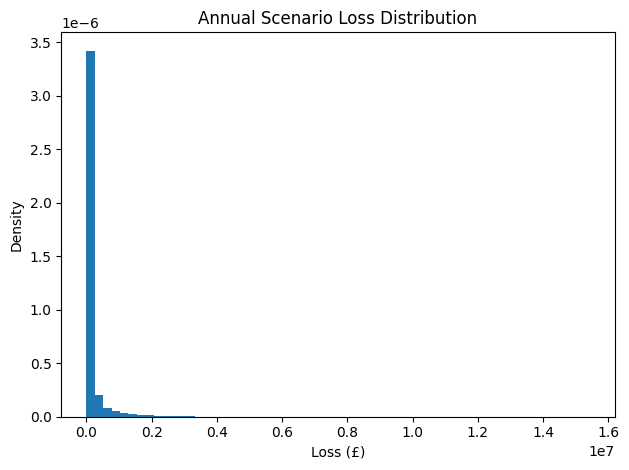

In [6]:
plt.figure()
plt.hist(annual_losses, bins=60, density=True)
plt.title('Annual Scenario Loss Distribution')
plt.xlabel('Loss (£)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

## 3) Loss Distribution Approach (Frequency-Severity)

In [7]:
# Assume 7 Basel op risk event types aggregated: use Poisson freq and lognormal severity (toy)
event_types = ['Internal Fraud','External Fraud','Employment Practices','Clients/Products','Damage to Assets','Business Disruption','Execution & Delivery']
lam = np.array([2.0, 4.0, 1.2, 3.0, 0.6, 1.5, 5.0])  # annual average counts
sev_mu = np.array([11.0, 10.5, 10.8, 11.2, 12.0, 11.5, 9.8])
sev_sigma = np.array([0.9, 0.8, 0.7, 0.9, 1.1, 0.8, 0.6])

years = 10000
rng = np.random.default_rng(99)
loss_year = np.zeros(years)
for i in range(len(event_types)):
    n_i = rng.poisson(lam[i], size=years)
    # For efficiency, draw a large pool and index
    draw_sizes = int(n_i.max()) if years>0 else 0
    pool = rng.lognormal(mean=sev_mu[i], sigma=sev_sigma[i], size=(years, draw_sizes if draw_sizes>0 else 1))
    mask = np.arange(pool.shape[1])[None, :] < n_i[:, None]
    loss_year += (pool * mask).sum(axis=1)

LDA_EL = loss_year.mean()
LDA_VaR = np.quantile(loss_year, 0.999)
LDA_ES = loss_year[loss_year>=LDA_VaR].mean()
pd.Series({'LDA EL (£)': LDA_EL, 'LDA VaR 99.9% (£)': LDA_VaR, 'LDA ES 99.9% (£)': LDA_ES})

LDA EL (£)          1,285,860.1796
LDA VaR 99.9% (£)   6,965,014.8196
LDA ES 99.9% (£)    9,375,632.8064
dtype: float64

### Plot LDA Annual Loss Distribution

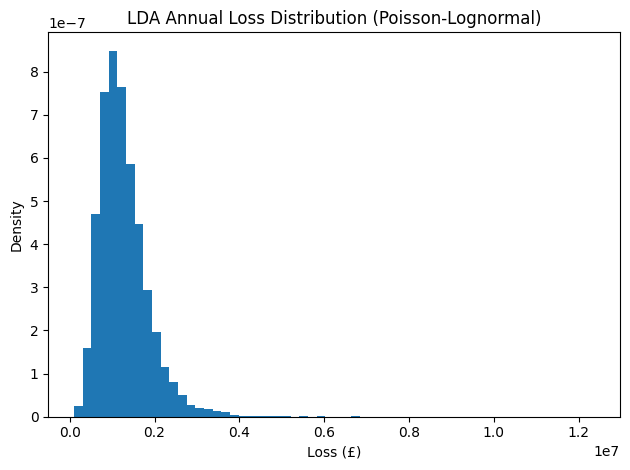

In [8]:
plt.figure()
plt.hist(loss_year, bins=60, density=True)
plt.title('LDA Annual Loss Distribution (Poisson-Lognormal)')
plt.xlabel('Loss (£)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

## 4) Combine Scenario Layer and LDA (Toy Capital)

In [18]:
combined = [loss_year + annual_losses]
EL_c = combined.mean()
VaR_c = np.quantile(combined, 0.999)
ES_c = combined[combined>=VaR_c].mean()
pd.Series({'Combined EL (£)': EL_c, 'Combined VaR 99.9% (£)': VaR_c, 'Combined ES 99.9% (£)': ES_c})

ValueError: operands could not be broadcast together with shapes (10000,) (20000,) 

## 5) Model Risk — Inventory & Validation Scoring

In [10]:
# Simple model inventory
inventory = pd.DataFrame([
    {'Model':'Credit PD Model','Owner':'Retail Risk','Use':'IRB PD','Status':'Production'},
    {'Model':'Market VaR Engine','Owner':'Traded Risk','Use':'IMA VaR/ES','Status':'Production'},
    {'Model':'OpRisk LDA','Owner':'Non-Fin Risk','Use':'Capital Planning','Status':'Development'},
    {'Model':'ALM Liquidity','Owner':'Treasury','Use':'LCR/NSFR','Status':'Production'},
], columns=['Model','Owner','Use','Status'])
inventory

,Model,Owner,Use,Status
0,Credit PD Model,Retail Risk,IRB PD,Production
1,Market VaR Engine,Traded Risk,IMA VaR/ES,Production
2,OpRisk LDA,Non-Fin Risk,Capital Planning,Development
3,ALM Liquidity,Treasury,LCR/NSFR,Production


### Validation Checklist (Scored)

In [11]:
# Criteria: data quality, conceptual soundness, implementation, monitoring, documentation
checklist = pd.DataFrame([
    {'Model':'Credit PD Model','Data':4,'Concept':4,'Implementation':4,'Monitoring':3,'Docs':4},
    {'Model':'Market VaR Engine','Data':3,'Concept':4,'Implementation':3,'Monitoring':3,'Docs':3},
    {'Model':'OpRisk LDA','Data':2,'Concept':3,'Implementation':2,'Monitoring':2,'Docs':2},
    {'Model':'ALM Liquidity','Data':4,'Concept':3,'Implementation':4,'Monitoring':3,'Docs':3},
], columns=['Model','Data','Concept','Implementation','Monitoring','Docs'])
checklist['Total'] = checklist[['Data','Concept','Implementation','Monitoring','Docs']].sum(axis=1)
checklist['Rating'] = pd.cut(checklist['Total'], bins=[0,10,15,20], labels=['Weak','Adequate','Strong'])
checklist.sort_values('Total', ascending=False)

,Model,Data,Concept,Implementation,Monitoring,Docs,Total,Rating
0,Credit PD Model,4,4,4,3,4,19,Strong
3,ALM Liquidity,4,3,4,3,3,17,Strong
1,Market VaR Engine,3,4,3,3,3,16,Strong
2,OpRisk LDA,2,3,2,2,2,11,Adequate


## 6) KRIs & Event Data Templates (Exportable)

In [15]:
kri = pd.DataFrame([
    {'KRI':'High-severity incidents (last 90d)','Value':5,'Threshold':3},
    {'KRI':'P1 outages (last 30d)','Value':2,'Threshold':1},
    {'KRI':'Open audit issues >90d overdue','Value':4,'Threshold':0},
], columns=['KRI','Value','Threshold'])

events = pd.DataFrame([
    {'Date':'2025-07-02','EventType':'Business Disruption','Loss':250000.0,'Description':'Data center outage'},
    {'Date':'2025-08-11','EventType':'External Fraud','Loss':140000.0,'Description':'Phishing-related card fraud'},
], columns=['Date','EventType','Loss','Description'])

kri.to_csv('oprisk_kri_template.csv', index=False)
events.to_csv('oprisk_event_log_template.csv', index=False)

## 7) Discussion Prompts
- Where should **scenario analysis** override LDA tails? How to avoid double counting?
- What governance gates must a model pass (policy, inventory, periodic review, change control)?
- How do **data lineage** and **feature drift** monitoring reduce model risk?
- Which KRIs best anticipate op-risk losses in your environment?